# Time Series Prediction : Corporation Favorita Grocery

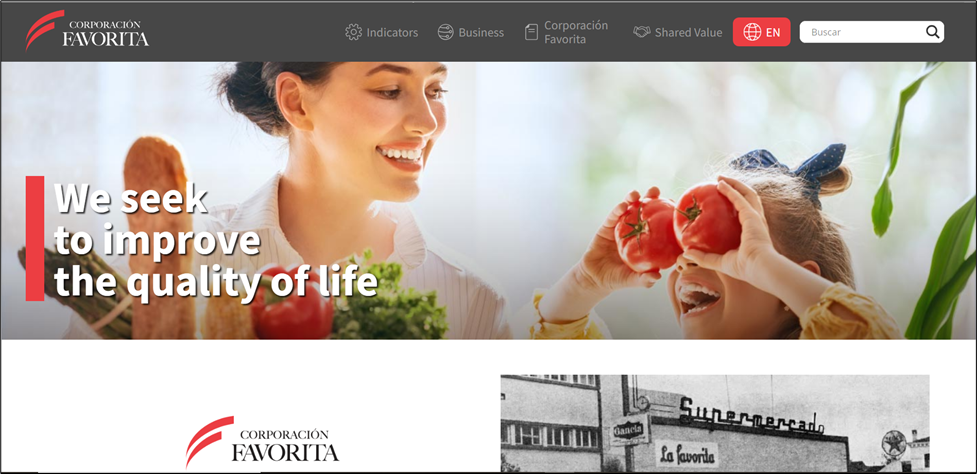

# Project Describtion

Corporación Favorita is Ecuador’s largest retailer, with over US$1.9 billion in sales and US$1.6 billion in total assets. It sells consumer products through its network of more than 150 supermarkets (Supermaxi, Megamaxi, Aki, Gran Aki, Super Aki, Jugueton, Supersaldos and Titán) located throughout the country’s provinces. It also operates in the commercial, industrial and real estate sectors, and has subsidiaries in six other countries in the region.

Link : https://www.corporacionfavorita.com/en/

# Setup 

In [175]:
# For controlling warnings
import warnings

warnings.filterwarnings('ignore')

#%pip install python-dotenv

#%pip install pyodbc

#%pip install pickle

# Importation

In [176]:
# For loading data and related works
import numpy as np
import pandas as pd

# For controlling warnings
import warnings

# For data visualizatioon
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For connecting to the database
import pyodbc

# For stating hypothesis
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

# For correcting seasonality
import statsmodels.api as sm

# For feature encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,  MinMaxScaler

# For managing date
import datetime

# For metrics
from sklearn.metrics import mean_squared_error , mean_squared_log_error

# For modeling
from statsmodels.tsa.arima.model import ARIMA

# For operating system
import os
import pickle

# For hidding sensitive datas
from dotenv import load_dotenv, dotenv_values

warnings.filterwarnings('ignore')

# Data Loading

The data for this project resides in this process. a database , onedrive and Github.

## Loading data from database 

In [3]:
env_var = dotenv_values(".env")

In [4]:
load_dotenv()

True

In [5]:
server = env_var.get("SERVER")
database = env_var.get("DATABASE")
username = env_var.get("USERNAME_")
password = env_var.get("PASSWORD")

In [6]:
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [7]:
#  This line of code depends on network stability, please try again if there is a problem
connection = pyodbc.connect(connection_string)




### 1. Loading oil table 

In [8]:
query = "Select * from dbo.oil"
data_oil = pd.read_sql(query, connection, parse_dates=["date"])

In [9]:
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [10]:
data_oil.to_csv("data_oil")

### 2. Loading holiday_event table

In [11]:
query = "Select * from dbo.holidays_events"
data_holiday_event = pd.read_sql(query, connection , parse_dates=["date"])

In [12]:
data_holiday_event.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [13]:
data_holiday_event.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [14]:
data_holiday_event.rename(columns = {"type" :"holiday_type" } , inplace = True)

In [15]:
data_holiday_event.head()

,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [16]:
data_holiday_event.to_csv("data_holiday_event")

### 3. Loading store table

In [17]:
query = "Select * from dbo.stores"
data_store = pd.read_sql(query, connection)

In [18]:
data_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
data_store.to_csv("data_store")

### 5. Loading train table

In [20]:
data_train = pd.read_csv("store-sales-forecasting/train.csv" , parse_dates=["date"])

In [21]:
data_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [22]:
#data_train.to_csv("data_train.csv")

In [23]:
data_transaction = pd.read_csv("store-sales-forecasting/transactions.csv" , parse_dates=["date"])

In [24]:
data_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [25]:
data_transaction.to_csv("data_transaction")

### 6. Loading test data 

In [26]:
data_test = pd.read_csv("test.csv" , parse_dates=["date"])

In [27]:
data_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


# Merging data

Merging data in time series analysis is a process of combining two or more time series datasets into one, based on a common time index or a key variable. Merging data can help to enrich the information available for analysis, to compare different sources of data, or to align data with different frequencies or granularities. Merging data requires careful attention to the alignment, interpolation, and aggregation of the data, as well as the handling of missing values and outliers.

In [28]:
oil_list = list(data_oil.columns)
holiday_event_list = list(data_holiday_event.columns)
store_list = list(data_store.columns)
train_list = list(data_train.columns)

In [29]:
print(oil_list)
print(holiday_event_list)
print(store_list)
print(train_list)

['date', 'dcoilwtico']
['date', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred']
['store_nbr', 'city', 'state', 'type', 'cluster']
['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']


## We can see that there are relations between our datasets. so by using their relational columns to merge them

In [30]:
data_oil_and_holiday_event = pd.merge(data_holiday_event , data_oil , on = "date" )
data_oil_and_holiday_event = data_oil_and_holiday_event[data_oil_and_holiday_event["date"].notnull()]
data_oil_and_holiday_event.head()

,date,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,2013-02-11,Holiday,National,Ecuador,Carnaval,False,97.010002
2,2013-02-12,Holiday,National,Ecuador,Carnaval,False,97.480003
3,2013-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,97.099998
4,2013-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,91.230003


In [31]:
print(store_list)
print(train_list)

['store_nbr', 'city', 'state', 'type', 'cluster']
['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']


In [32]:
data_store_and_train = pd.merge(data_store , data_train , on = "store_nbr" )
data_store_and_train = data_store_and_train[data_store_and_train["store_nbr"].notnull()]
data_store_and_train.head()

,store_nbr,city,state,type,cluster,id,date,family,sales,onpromotion
0,1,Quito,Pichincha,D,13,0,2013-01-01,AUTOMOTIVE,0.0,0
1,1,Quito,Pichincha,D,13,1,2013-01-01,BABY CARE,0.0,0
2,1,Quito,Pichincha,D,13,2,2013-01-01,BEAUTY,0.0,0
3,1,Quito,Pichincha,D,13,3,2013-01-01,BEVERAGES,0.0,0
4,1,Quito,Pichincha,D,13,4,2013-01-01,BOOKS,0.0,0


In [33]:
store_and_train_list = list(data_store_and_train.columns)
oil_and_holiday_event_list = list(data_oil_and_holiday_event.columns)

In [34]:
print(store_and_train_list)
print(oil_and_holiday_event_list)

['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'date', 'family', 'sales', 'onpromotion']
['date', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'dcoilwtico']


In [35]:
data_store_and_train.shape , data_oil_and_holiday_event.shape

((3000888, 10), (202, 7))

In [36]:
data_final = pd.merge(data_store_and_train , data_oil_and_holiday_event , on = "date" )
data_final = data_final[data_final["date"].notnull()]
data_final.head()

,store_nbr,city,state,type,cluster,id,date,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,1,Quito,Pichincha,D,13,0,2013-01-01,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,1,Quito,Pichincha,D,13,1,2013-01-01,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,1,Quito,Pichincha,D,13,2,2013-01-01,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
3,1,Quito,Pichincha,D,13,3,2013-01-01,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
4,1,Quito,Pichincha,D,13,4,2013-01-01,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN


### Finally data's used for training are meged into one dataset

Inroder to to keep the training data safe from any imputation when working on EDA and other things. Let us keep copy the data.

In [37]:
data_train = data_final
data_train.head()

,store_nbr,city,state,type,cluster,id,date,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,1,Quito,Pichincha,D,13,0,2013-01-01,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,1,Quito,Pichincha,D,13,1,2013-01-01,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,1,Quito,Pichincha,D,13,2,2013-01-01,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
3,1,Quito,Pichincha,D,13,3,2013-01-01,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
4,1,Quito,Pichincha,D,13,4,2013-01-01,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN


In [38]:
#data_train.to_csv("data_train2.csv")

In [39]:
data_final = data_final.set_index("date")
data_final["year"] = data_final.index.year
data_final["month"] = data_final.index.month
data_final["weekday name"] = data_final.index.day_name()
data_final["day"] = data_final.index.day

# Hypothesis Testing

Hypothesis testing is a statistical method to test the validity of a claim or an assumption about a population parameter, such as the mean, the proportion, or the correlation. Hypothesis testing involves four steps: 
1) stating the null and alternative hypotheses, 

2) choosing a significance level and a test statistic, 

3) calculating the p-value or the critical value, and 

4) making a decision to reject or fail to reject the null hypothesis based on the evidence. 

## Test - 1

<b>Null Hypothesis</b> : Series is non-stationary means possess unit root

<b>Alternative Hypothesis</b> : Series is stationary means do not possess unit root

<b>Note</b> : Unit root is a characteristic of a time series that makes it non-stationary. Series, in our senario, is a month.

In [40]:
# assigning the column month values to series variable
series = data_final.loc[:, 'month'].values
series

array([1, 1, 1, ..., 8, 8, 8], dtype=int64)

**Before going to test the hypothesis, first let see how the the series is going using line plot**

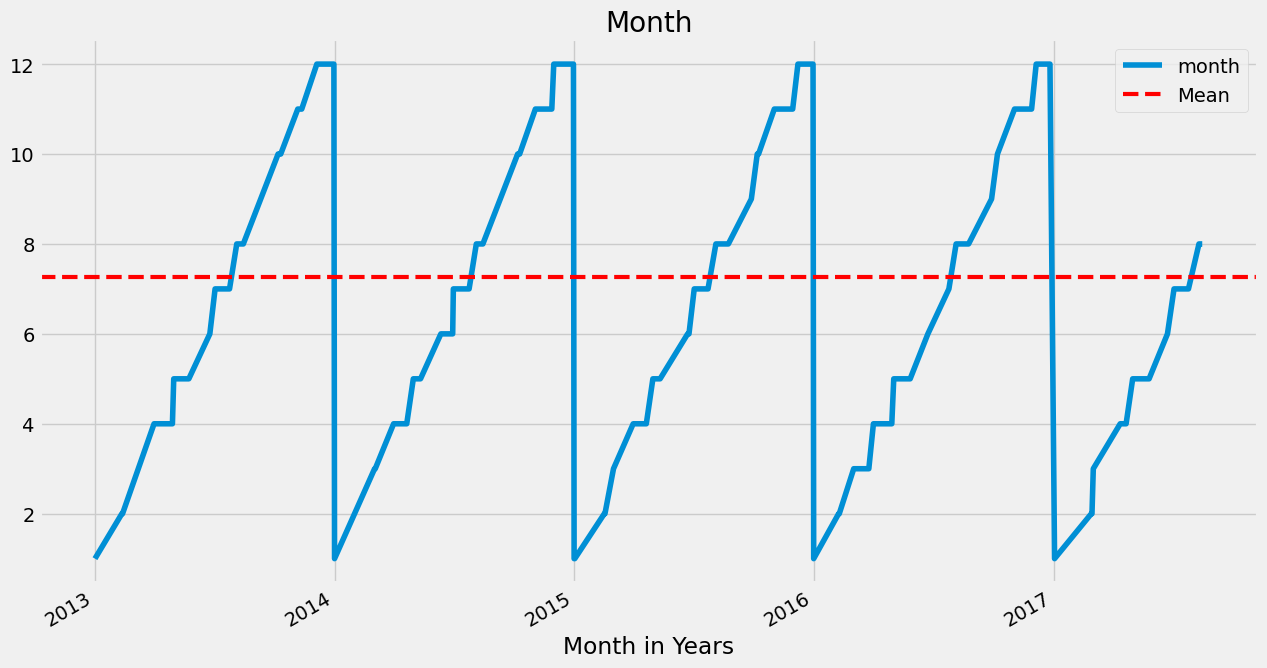

In [178]:
# a plot for the month column
data_final.month.plot(figsize=(14,8), legend=None, title='Month' , xlabel = "Month in Years")

# Selecting plot style
plt.style.use("fivethirtyeight")

# a plot for average month throught the whole years
plt.axhline(y=np.nanmean(data_final.month) , color='red', linestyle='--', linewidth=3, label='Mean')
plt.legend()

**Just by looking into the graph,there is cyclic and it seems staionary. Because the mean is stationary which means it does not change when data point of a series chages overtime.**

### Augmented Dickey-Fuller (ADF)

The Augmented Dickey-Fuller (ADF) test is a statistical test that can be used to test whether a time series is stationary or not. Stationarity means that the statistical properties of the time series, such as the mean, variance, and autocorrelation, do not change over time. Stationarity is an important assumption for many time series models and methods.

In [42]:
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -3.7527414221951516
n_lags: 0.0034295783190151793
p-value: 0.0034295783190151793
Critial Values:
   1%, -3.4303685337270258
Critial Values:
   5%, -2.861548191681665
Critial Values:
   10%, -2.5667743601342305


**Clearly as p-value is less than singificant level (0.05), there is no reason to accept the null hypothesis. So, the time series is in fact stationary.**

## Test - 2

Null Hypothesiss : There is no significant relation between daily price and amount of sale

Alternative Hypothesis : There is a significant relation between daily price and amount of sale

In [43]:
sample_data = data_final.sample(n=None, frac=0.5, replace=False, weights=None, random_state=2, axis=0)

In [44]:
sample1 = sample_data["store_nbr"]
sample2 = sample_data["sales"]

In [45]:
sample1 = sample1.dropna()
sample2 = sample2.dropna()

In [46]:
sample1.shape , sample2.shape

((176418,), (176418,))

In [47]:
# Import libraries
from scipy import stats
import numpy as np

# Perform a t-test
t_stat, p_value = stats.ttest_ind(sample1, sample2)

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: -123.86023257210132
p-value: 0.0


In [48]:
alpha = 0.05
if p_value > alpha:
    print("accept the null hypothesis")
else:
    print("reject null hypothesis ")

reject null hypothesis 


**Null hypothesis is rejected. This means there is a relation between daily price oil and sales amount.**

In [49]:
data_tmp = data_final.dropna()
np.corrcoef(
    data_tmp["dcoilwtico"],
    data_tmp["sales"]
)

array([[ 1.        , -0.07511643],
       [-0.07511643,  1.        ]])

**Daily Oil oil pricily sales are negaticely correlated. When one feature increases the other become decreases.**

In [50]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352836 entries, 2013-01-01 to 2017-08-15
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_nbr     352836 non-null  int64  
 1   city          352836 non-null  object 
 2   state         352836 non-null  object 
 3   type          352836 non-null  object 
 4   cluster       352836 non-null  int64  
 5   id            352836 non-null  int64  
 6   family        352836 non-null  object 
 7   sales         352836 non-null  float64
 8   onpromotion   352836 non-null  int64  
 9   holiday_type  352836 non-null  object 
 10  locale        352836 non-null  object 
 11  locale_name   352836 non-null  object 
 12  description   352836 non-null  object 
 13  transferred   352836 non-null  bool   
 14  dcoilwtico    322542 non-null  float64
 15  year          352836 non-null  int64  
 16  month         352836 non-null  int64  
 17  weekday name  352836 non-null  o

In [51]:
# checking for NaN in dataframe dcoilwtico column
data_final.query("dcoilwtico != dcoilwtico").head()

,store_nbr,city,state,type,cluster,id,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,weekday name,day
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,Quito,Pichincha,D,13,0,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,2013,1,Tuesday,1
2013-01-01,1,Quito,Pichincha,D,13,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,2013,1,Tuesday,1
2013-01-01,1,Quito,Pichincha,D,13,2,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,2013,1,Tuesday,1
2013-01-01,1,Quito,Pichincha,D,13,3,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,2013,1,Tuesday,1
2013-01-01,1,Quito,Pichincha,D,13,4,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,2013,1,Tuesday,1


In [52]:
data_final.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'family',
       'sales', 'onpromotion', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico', 'year', 'month',
       'weekday name', 'day'],
      dtype='object')

In [53]:
data_train = data_train.drop_duplicates()
data_final["year"] = data_final.index.year
data_final["month"] = data_final.index.month
data_final["weekday name"] = data_final.index.day_name()

# Questions with EDA

## Univariate Analysis

### 1. how is the daily price of oil momement over the year?

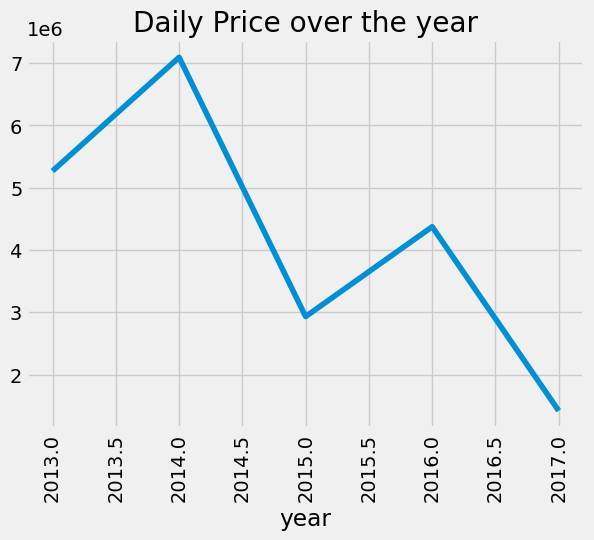

In [181]:
data_final.groupby("year").sum()["dcoilwtico"].plot(grid=True , title = "Daily Price over the year")
plt.xticks(rotation = 90)
plt.show()

The graph show a seasonality change on price of oil. The first year can affect the next one by giving an inverse result. For example when we look at 2013 the price is increasing, then the next year,2014, is decreasing. The same thing percieved in 2015 which increase the price because of the last year was decresing. It has up and down flow over the years.

### 2. What is the oil price in 2016?

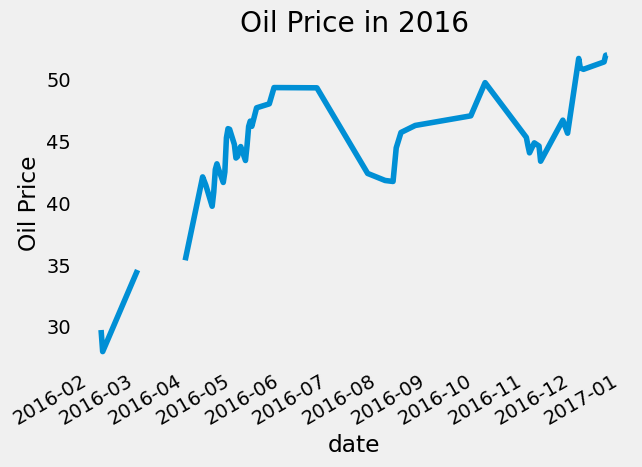

In [182]:
data_final[data_final["year"] == 2016].dcoilwtico.plot(ylabel ="Oil Price" , title = "Oil Price in 2016")
plt.grid()

For the first five month there is an upward trend. From senventh month to the end of year the plot has irregular variation

This graph tell us **unexpected result. It is not usual for market as the price of oil increase also the year become the top record on sale.**

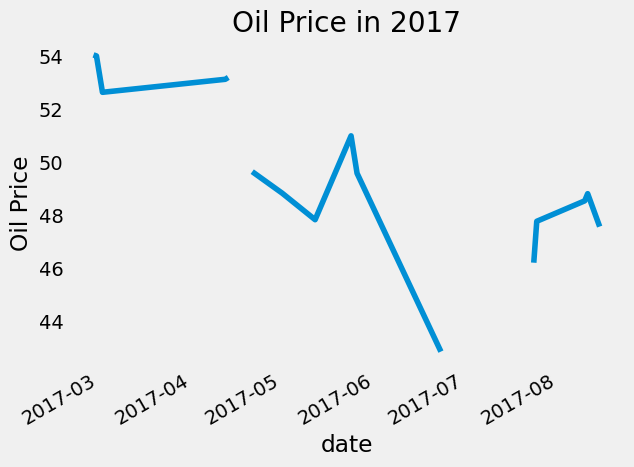

In [183]:
data_final[data_final["year"] == 2017].dcoilwtico.plot(ylabel ="Oil Price" , title = "Oil Price in 2017")
plt.grid()

There is irregular variation standing from the graph, price of oil is downgrading as the month increases. and from both 2016 and 2017 data, the is an inverse relation between month increasng and price of oil decresing.

## Bivariate Analysis

### 1. Which city have a high number of promotion?

In [185]:
promotion_city = data_final.groupby("city").count()["onpromotion"].sort_values(ascending=False).head(5)
promotion_city = pd.DataFrame({'year':promotion_city.index, 'amount':promotion_city.values})

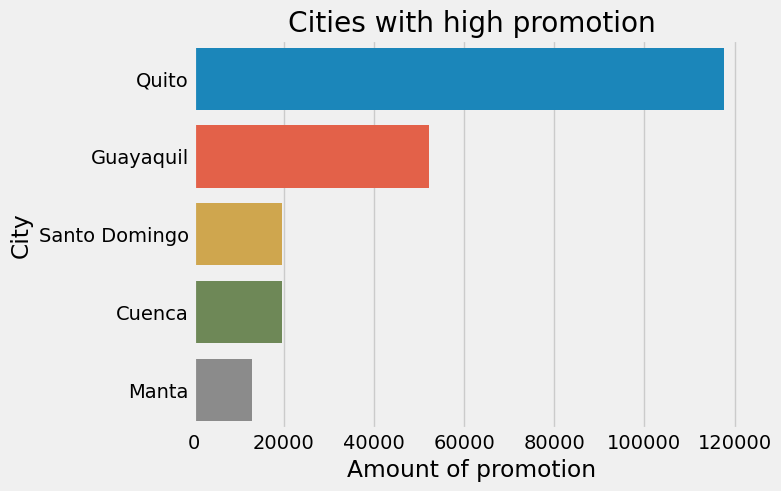

In [210]:
# Create horizontal barplot

ax = plt.subplots() 

sns.barplot(x=promotion_city.amount , y=promotion_city.year, orient = "h")
ax[1].set(ylabel= "City" )

#add axis labels
plt.xlabel('Amount of promotion')
plt.title("Cities with high promotion")
plt.show()


A city named as "Quito" has more than 100  thousand promotions over the past five years. "Guayaquil" also takes a promotion in the city around 50 thousand.

### 2. Which year has a high number of promotion?

In [188]:
promotion_year = data_final.groupby("year").count()["onpromotion"].sort_values(ascending=False).head(5)

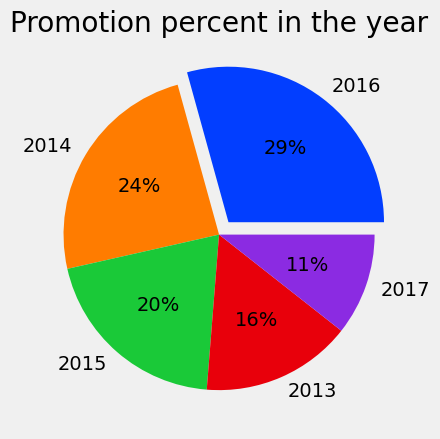

<Figure size 1500x1500 with 0 Axes>

In [214]:
#define data
data = promotion_year
labels = ['2016', '2014', '2015', "2013" , "2017" ]

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

# declaring exploding pie
explode = [0.1, 0, 0, 0, 0]

#create pie chart
plt.pie(data, labels = labels, explode = explode , colors = colors, autopct='%.0f%%' )
plt.title("Promotion percent in the year")
plt.figure(figsize=(15, 15))
plt.show()


**year 2016 has a high number of promotion. It take 29 percent from the whole years. 2015 also has one five total year promotion.**

### 3. Which cities have a high amount of sale transactions?

In [208]:
sale_city = data_final.groupby("city").count()["sales"].sort_values(ascending=False).head(5)
sale_city = pd.DataFrame({'year':sale_city.index, 'amount':sale_city.values})

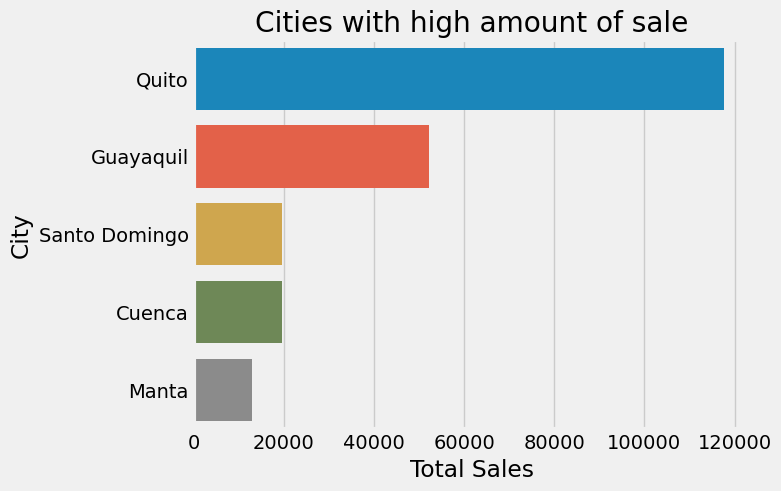

In [209]:
# create horizontal barplot

ax = plt.subplots() 

sns.barplot(x = sale_city.amount , y = sale_city.year, orient = "h")
ax[1].set(ylabel= "City" )

#add plot title
sns.title = 'Total Sales by Employee'

#add axis labels
plt.xlabel('Total Sales')
#plt.ylabel('City')
plt.title("Cities with high amount of sale")
plt.show()

It a good understanding to plot cities with thier promotion and sales. A city which has a high promotion must have a good amount of sales,  Previously in question one we have seen that a city called "Quito" is the most promtotion worked. The same is true it has a good amount of sale.


### 4. Show the relation between daily oil price and amount of sales 

In [215]:
price_year = data_final.groupby("year").sum()["dcoilwtico"]
price_year = pd.DataFrame({'year':price_year.index, 'sale_amount':price_year.values})
price_year

,year,sale_amount
0,2013,5.268839e+06
1,2014,7.093661e+06
2,2015,2.931069e+06
3,2016,4.373081e+06
4,2017,1.417777e+06


In [216]:
oil_year = data_final.groupby("year").sum()["sales"]
oil_year = pd.DataFrame({'year':oil_year.index, 'oil_price':oil_year.values})
oil_year

,year,oil_price
0,2013,1.166394e+07
1,2014,2.809424e+07
2,2015,2.752824e+07
3,2016,4.568113e+07
4,2017,1.792345e+07


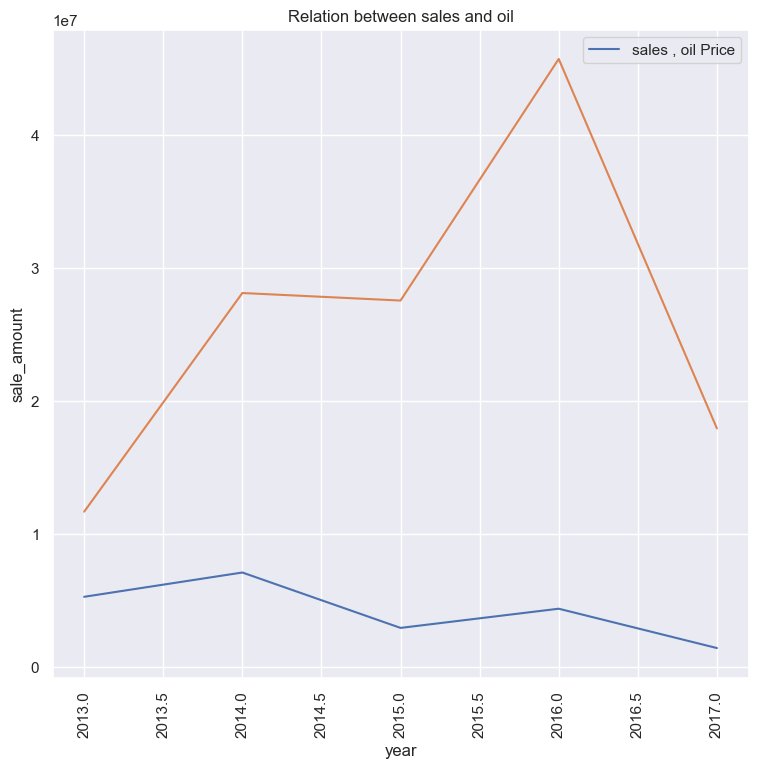

In [229]:
sns.lineplot(x = "year", y = "sale_amount", data=price_year)
sns.lineplot(x = "year", y = "oil_price", data=oil_year )

sns.set(rc={"figure.figsize" :(8, 10)})
plt.legend(labels = ["sales , oil Price" ] )
plt.title("Relation between sales and oil")
plt.xticks(rotation = 90)
plt.show()

The price of oil affects the amount of sales in the company. Both features, oil and sales, are postively related. When the price of oil increases the amount of sale also increases.

Unblievable but acceptable, In other countries, who have no oil direct resource, the price of oil can decreases amount of sale. because everything becomes very expensive and peoples can not affrod their interest. whereas in this country there is too much resource os oil. companies are not highly affected by price of oil

### 5. Which holiday type has high amount sale?

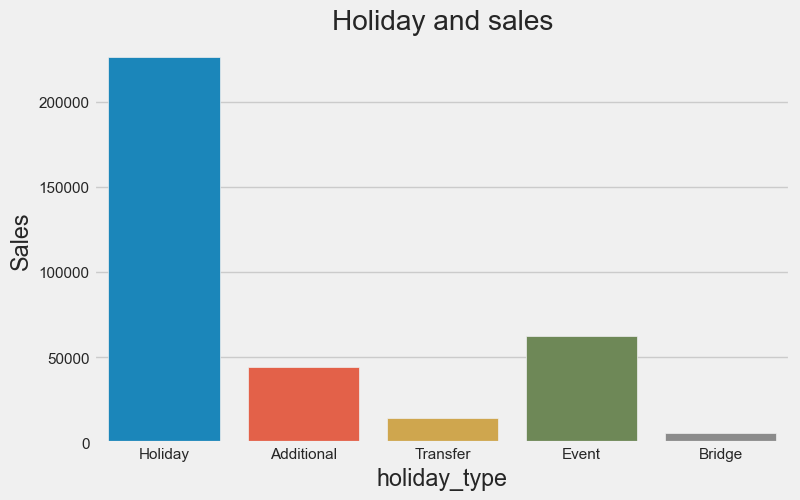

In [241]:
ax = plt.subplots() 

sns.countplot(x="holiday_type", data=data_final)
ax[1].set(ylabel= "Sales" )

#add plot title
sns.title = 'Total Sales by Employee'

plt.style.use("fivethirtyeight")
#sns.set(rc={"figure.figsize" :(8, 5)})
plt.title("Holiday and sales")
#plt.xlabel("Holiday type")
#plt.ylabel("Sales")

plt.show()

**Holiday has the major from all types. It supports that peoples are enjoying on holidays and the company got a high income.
The next one is an event which has 50 thousand sales.**


### 6. show amount of sale in each store

<AxesSubplot:title={'center':'Amount of sales per store number'}, xlabel='store_nbr', ylabel='Amount of Sale'>

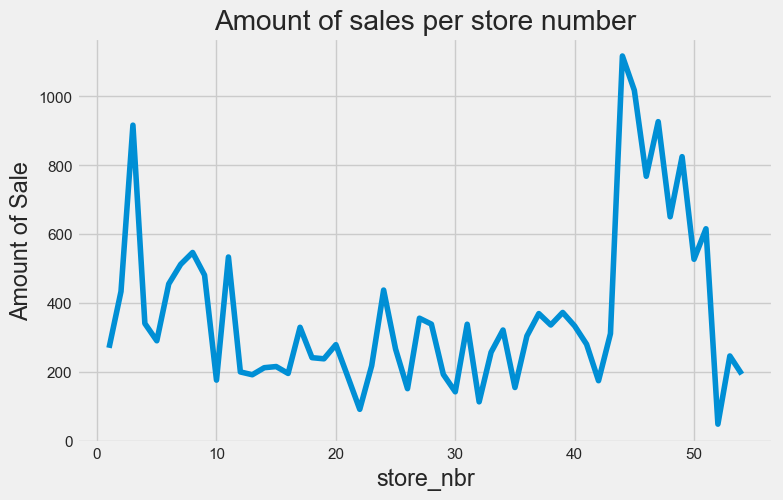

In [242]:
data_final.groupby("store_nbr")["sales"].mean().plot(ylabel="Amount of Sale" , title = "Amount of sales per store number")

**A sale of stores are different from one to another. There is an increasing amount os saling in store 0 to 5. Also stores labled from 40 to 50 has a seasonal variation.**

### 7. What is the number of cluster per each month?

<AxesSubplot:title={'center':'Numer of Cluster per Month'}, xlabel='month', ylabel='Numberof ckuster'>

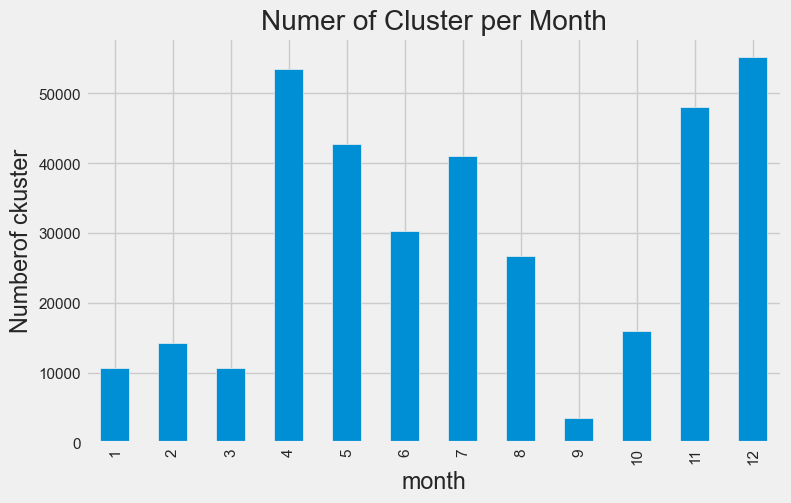

In [243]:
plt.ylabel = "Sales Amount"
data_final.groupby("month").count()["cluster"].plot(ylabel="Numberof ckuster"   , kind = "bar",  title = "Numer of Cluster per Month" )

**on April and December month there was more than 50 thousand cluster. Cluster is  group of store. Inother word there are pltnty of stores in the specified months. September holds the minimum number of stores or cluster.**

### 8. Show amount of sale per each year

<AxesSubplot:title={'center':'Sales per Year'}, xlabel='year', ylabel='Amount of Sale'>

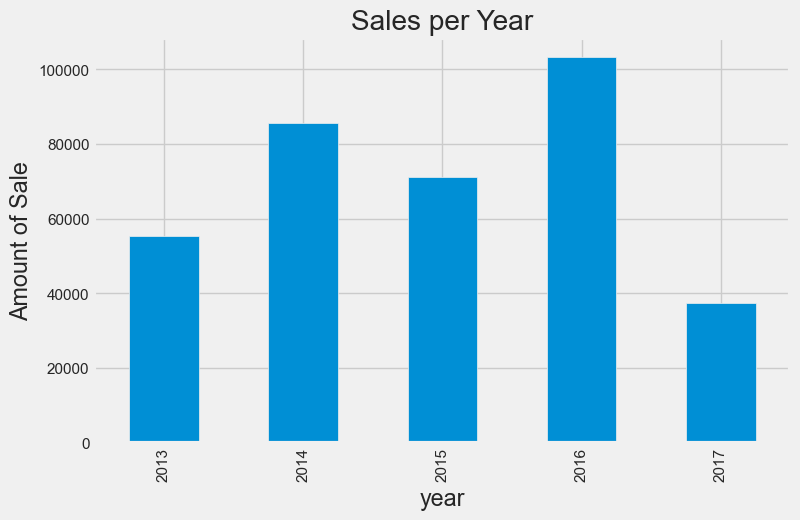

In [244]:
plt.ylabel = "Sales Amount"
data_final.groupby("year").count()["sales"].plot(ylabel="Amount of Sale"   , kind = "bar",  title = "Sales per Year" )

**Year 2016 has the largest sale from our records. 2017 , in other side, make a round 30 thousand sales. The rest years are ranges from 50 to 80 thound of sales.**

## Multi variate Analysis

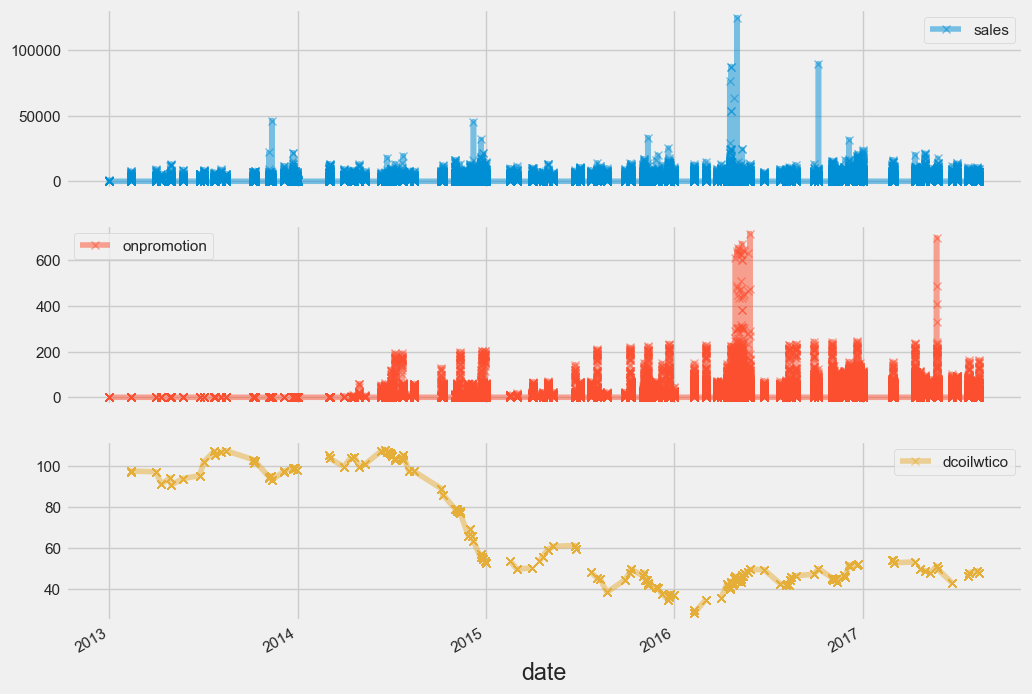

In [245]:
cols_plot = ["sales" , "onpromotion" , "dcoilwtico" ]
axes = data_final[cols_plot].plot(marker = "x" , alpha = 0.5 , figsize = (11 , 9) ,subplots = True , grid=True)


A plot can inform us promotion is not high as the oil price is too much. Briefly can conclude that for high number of promotion there must be cheap amount oil.

Oil is not in staionary mode. But its amount of daily oil sale is decreasing over the years. This is a greate opportunity in order to work with out any power problem in the company

In [246]:
pd.date_range("2016-01-01" , "2016-01-30" , freq="d")

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30'],
              dtype='datetime64[ns]', freq='D')

In [247]:
data_cols = ["sales" , "onpromotion" , "dcoilwtico"]
data_weekly_mean = data_final[data_cols].resample("W").mean()
data_weekly_mean.head()

,sales,onpromotion,dcoilwtico
date,,,
2013-01-06,1.409438,0.0,NaN
2013-01-13,NaN,NaN,NaN
2013-01-20,NaN,NaN,NaN
2013-01-27,NaN,NaN,NaN
2013-02-03,NaN,NaN,NaN


<AxesSubplot:title={'center':'Number of stores in cities'}, xlabel='city', ylabel='numer of stores'>

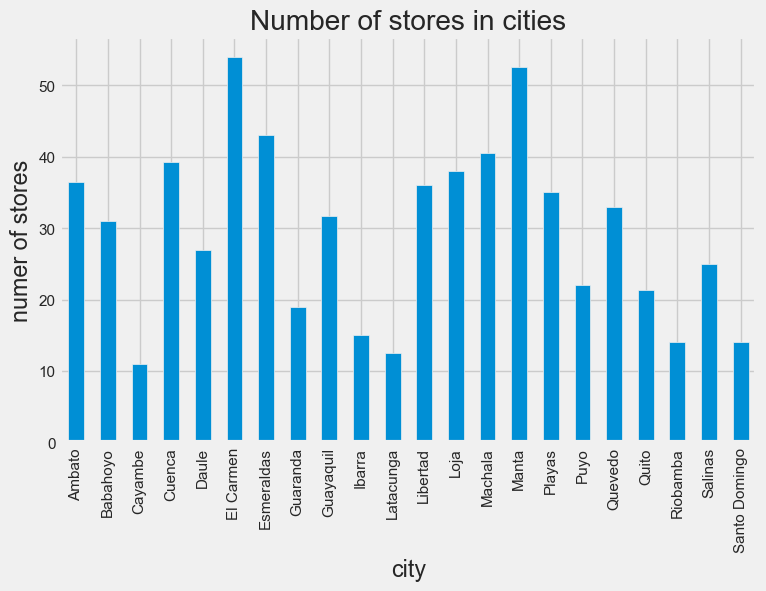

In [248]:
data_final.groupby("city").mean()["store_nbr"].plot(kind = "bar" , title = "Number of stores in cities" , ylabel = "numer of stores")

In [249]:
data_final.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'family',
       'sales', 'onpromotion', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico', 'year', 'month',
       'weekday name', 'day'],
      dtype='object')

## How many promotion are done on each year

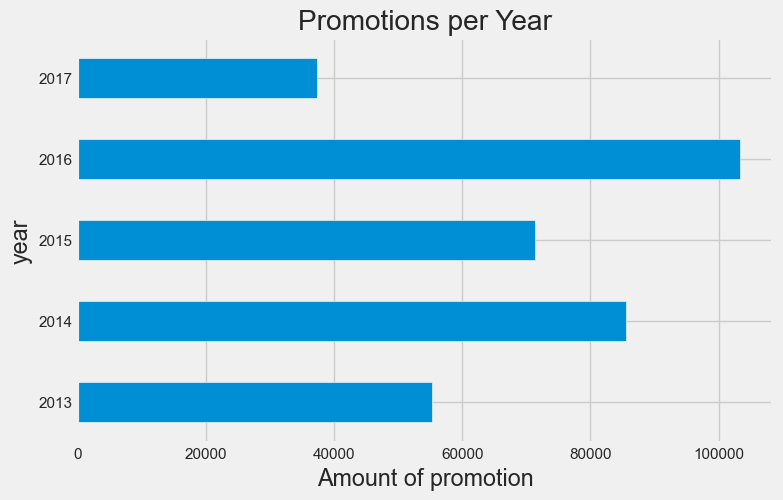

In [253]:
data_final.groupby("year").count()["onpromotion"].plot(kind = "barh", grid = True)
plt.title("Promotions per Year")
plt.xlabel("Amount of promotion")
plt.show()

**2016 and 2014 are the top promotion years.**

## What are the most usable family products

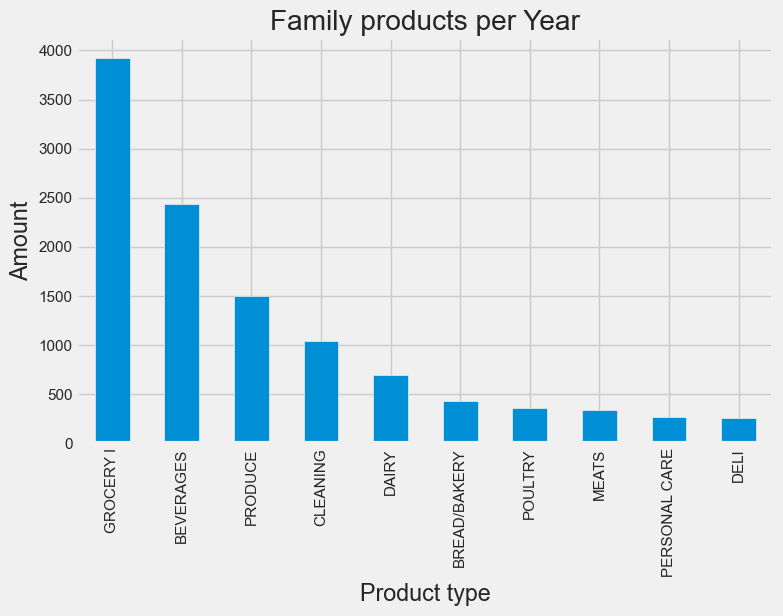

In [258]:
data_final.groupby("family").mean()["sales"].sort_values(ascending = False)[:10].plot(kind = "bar" , ylabel = "Amount" ,  grid = True)
plt.title("Family products per Year")
plt.xlabel("Product type")
plt.show()

## Grocery I and Beverages are the most usable products

# Data Preparation

Data preparation is a process of transforming raw data into a format that is suitable for analysis, modeling, or visualization. Data preparation can involve various steps, such as:

<b>Data cleaning:</b> removing or correcting errors, outliers, missing values, duplicates, or inconsistencies in the data.

<b>Data integration:</b> combining data from multiple sources or formats into a single dataset.

<b>Data transformation:</b> applying functions or operations to change the data values, types, or structures, such as scaling, encoding, aggregating, or reshaping

In [259]:
data = data_train.set_index("date")

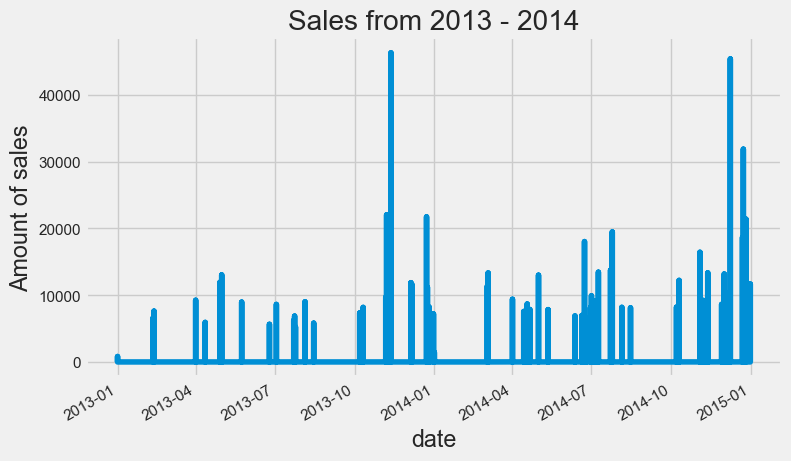

In [263]:
d = data
d["2013" : "2014"].sales.plot(title = "Sales from 2013 - 2014" , ylabel = "Amount of sales")
plt.show()

In [264]:
basic_columns = ["store_nbr" , "family" , "sales" , "onpromotion" , "date" ]

In [265]:
data = data.reset_index()
main_data = data[basic_columns]
main_data = main_data.set_index("date")
main_data.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


# completing missed dates

Completing missing dates in time series analysis is a process of filling in the gaps or holes in the data that occur when some dates or time periods are not recorded or observed. Completing missing dates can help to avoid errors or biases in the analysis, modeling, or forecasting of the time series

In [266]:
main_data.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


In [267]:
data = main_data.reset_index()

In [268]:
# convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# create a date range from the minimum to the maximum date in the dataframe
idx = pd.date_range(data['date'].min(), data['date'].max())

# reindex the dataframe with the date range and fill missing values with 0
df = data.reindex(idx, fill_value=0).reset_index()

# rename the index column to date
#df = data.rename(columns={'index': 'date'})

# print the result
data.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [269]:
# create a date range from the minimum to the maximum date in the dataframe
idx = pd.date_range(data['date'].min(), data['date'].max())

In [270]:
idx

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [271]:
# define a function to fill the missing dates
def fill_missing_dates(df, idx):
    # create an empty list to store the new rows
    new_rows = []
    # loop through the date range
    for date in idx:
        # check if the date is in the dataframe
        if date in df['date'].values:
            # get the rows that match the date
            rows = df[df['date'] == date]
            # append them to the new rows list
            new_rows.extend(rows.values.tolist())
        else:
            # create a new row with the date and 0 value
            new_row = [date, 0]
            # append it to the new rows list
            new_rows.append(new_row)
    # create a new dataframe from the new rows list
    new_df = pd.DataFrame(new_rows, columns=df.columns)
    # return the new dataframe
    return new_df


In [272]:
# apply the function to the dataframe and the date range
new_df = fill_missing_dates(data, idx)

# print the result
new_df.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,2013-01-01,1,BABY CARE,0.0,0.0
2,2013-01-01,1,BEAUTY,0.0,0.0
3,2013-01-01,1,BEVERAGES,0.0,0.0
4,2013-01-01,1,BOOKS,0.0,0.0


In [273]:
new_df = new_df.set_index("date")
new_df.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0
2013-01-01,1,BABY CARE,0.0,0.0
2013-01-01,1,BEAUTY,0.0,0.0
2013-01-01,1,BEVERAGES,0.0,0.0
2013-01-01,1,BOOKS,0.0,0.0


In [274]:
new_df = new_df.reset_index()
new_df.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,2013-01-01,1,BABY CARE,0.0,0.0
2,2013-01-01,1,BEAUTY,0.0,0.0
3,2013-01-01,1,BEVERAGES,0.0,0.0
4,2013-01-01,1,BOOKS,0.0,0.0


**Now we have filled the missed dates. But the dates have no records.**

In [275]:
new_df.isnull().sum()

date              0
store_nbr         0
family         1508
sales          1508
onpromotion    1508
dtype: int64

In [276]:
y = new_df.set_index("date")

In [277]:
y.sales.mean() , y.sales.min() , y.sales.max()

(370.9683960761568, 0.0, 124717.0)

In [278]:
y["2013"].sales.mean() , y["2013"].sales.min() , y["2013"].sales.max()

(211.14252469714532, 0.0, 46271.0)

# Interpolation

### Interpolation for numerical data

Interpolation for numerical values is a process of estimating unknown values between known values of a function or a data series. Interpolation can be used to fill in missing values, smooth out noise, or create finer resolution data. 

In [94]:
sas = new_df
sas.sales = sas.sales.interpolate()
sas.family = sas.family.interpolate()
sas.onpromotion = sas.onpromotion.interpolate()
sas.store_nbr = sas.store_nbr.interpolate()

In [95]:
sas.isnull().any()

date           False
store_nbr      False
family          True
sales          False
onpromotion    False
dtype: bool

In [96]:
y = sas.set_index("date")

### Interpolation for categorical column

Interpolation for categorical values is a process of estimating unknown values that belong to a discrete set of possible values, such as labels, classes, or categories. Interpolation for categorical values can be used to fill in missing values, impute values, or classify data.

In [280]:
y_codes = pd.Categorical(new_df["family"]).codes

In [281]:
x_new = []

for i in range ( len(new_df.family.unique()) - 1 ):
    x_new.append(i)

In [282]:
new_df[new_df.date == "2013-01-02"]

,date,store_nbr,family,sales,onpromotion
1782,2013-01-02,0,None,NaN,NaN


In [283]:
mode_family = sas.family.mode().max()

In [284]:
sas.family = sas.family.fillna(mode_family)

In [285]:
new_df = sas
new_df.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,2013-01-01,1,BABY CARE,0.0,0.0
2,2013-01-01,1,BEAUTY,0.0,0.0
3,2013-01-01,1,BEVERAGES,0.0,0.0
4,2013-01-01,1,BOOKS,0.0,0.0


In [286]:
new_df[new_df.date == "2013-02-02"]

,date,store_nbr,family,sales,onpromotion
1813,2013-02-02,0,SEAFOOD,0.0,0.0


In [287]:
new_df = new_df.set_index("date")

# Resampling to a date

Resampling in time series data is a process of changing the frequency or granularity of the data, such as from daily to monthly, or from hourly to weekly. Resampling can be used to aggregate, summarize, or smooth the data, or to create finer or coarser resolution data. Resampling can involve various methods, such as:

In [288]:
new_df = new_df.resample('1D', base=1).agg(lambda x: x.mode()[0])

In [289]:
( new_df.sales < 0).any()

False

**We are going to use 2013 years data for modeling**

In [290]:
new_df = new_df["2013"]
new_df.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0
2013-01-02,0,SEAFOOD,0.0,0.0
2013-01-03,0,SEAFOOD,0.0,0.0
2013-01-04,0,SEAFOOD,0.0,0.0
2013-01-05,0,SEAFOOD,0.0,0.0


# Correcting seasonality

Correcting seasonality is a process of removing or reducing the periodic fluctuations or patterns in the data that are related to the time of the year, such as seasons, quarters, months, weeks, or days. Correcting seasonality can help to reveal the underlying trend, cycle, or irregular components of the data, or to improve the accuracy of forecasting or modeling.

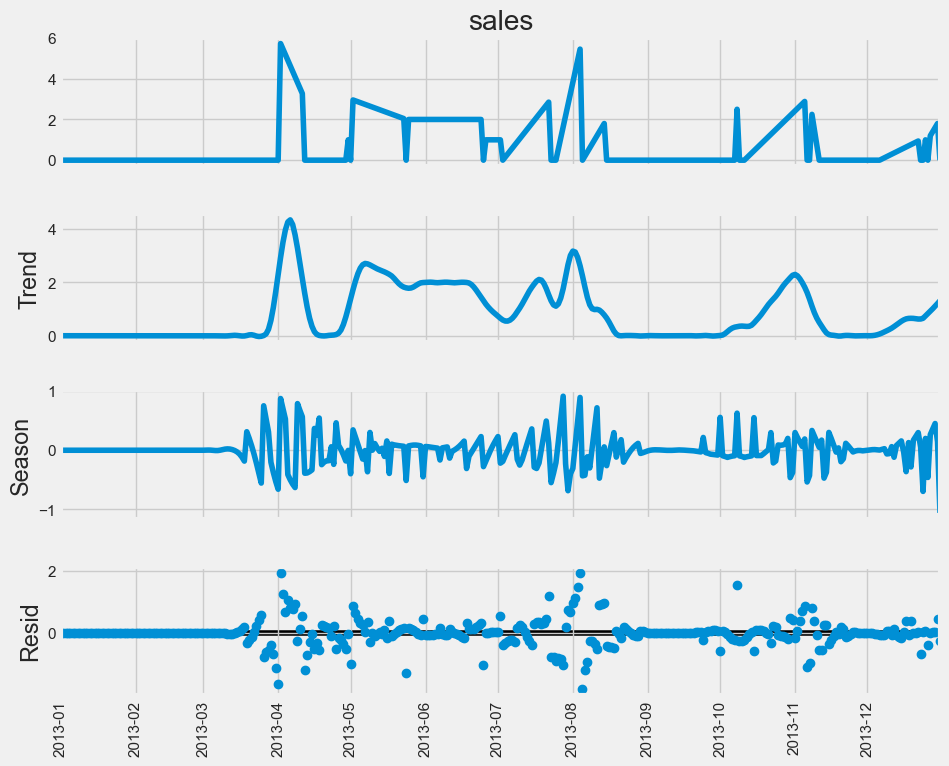

In [292]:
import statsmodels.api as sm

# use STL decomposition to decompose the time series into trend, seasonal, and residual components
stl = sm.tsa.STL(new_df.sales, seasonal=7)
res = stl.fit()

# plot the decomposition results
fig = res.plot()
fig.set_size_inches(10, 8)
plt.xticks(rotation = 90)
plt.show()

In [293]:
tst = res.resid

In [294]:
import numpy as np
x = np.expm1(tst)

In [295]:
tst.head()

date
2013-01-01    1.691654e-07
2013-01-02    6.719414e-08
2013-01-03   -3.948058e-09
2013-01-04   -3.970446e-08
2013-01-05   -7.213481e-08
Freq: D, Name: resid, dtype: float64

### correcting the negative number by adding constant number

In [112]:
#add a constant to make data positive
alpha = 1 - np.min(tst)
data_pos = tst + alpha
data_pos

date
2013-01-01    2.805619
2013-01-02    2.805619
2013-01-03    2.805619
2013-01-04    2.805619
2013-01-05    2.805619
                ...   
2013-12-27    2.819761
2013-12-28    2.833716
2013-12-29    2.845411
2013-12-30    3.253173
2013-12-31    2.550699
Freq: D, Name: resid, Length: 365, dtype: float64

# correcting outliers using yeo-johnson

Yeo-Johnson correction is a method of transforming the data to reduce the effect of outliers and make the data more symmetric or normal. Yeo-Johnson correction is a generalization of the Box-Cox transformation that can handle both positive and negative values. Yeo-Johnson correction applies a different function to the data depending on whether the values are positive, negative, or zero. 

In [296]:
# import the library
import pandas as pd

# generate some skewed data with outliers
x = data_pos

# define an outlier as a value that is more than 3 standard deviations from the mean
outliers = abs(x - x.mean()) > 3 * x.std()

# replace the outliers with the mean
x[outliers] = x.mean()

# print the corrected data
x

date
2013-01-01    2.805619
2013-01-02    2.805619
2013-01-03    2.805619
2013-01-04    2.805619
2013-01-05    2.805619
                ...   
2013-12-27    2.819761
2013-12-28    2.833716
2013-12-29    2.845411
2013-12-30    3.253173
2013-12-31    2.550699
Freq: D, Name: resid, Length: 365, dtype: float64

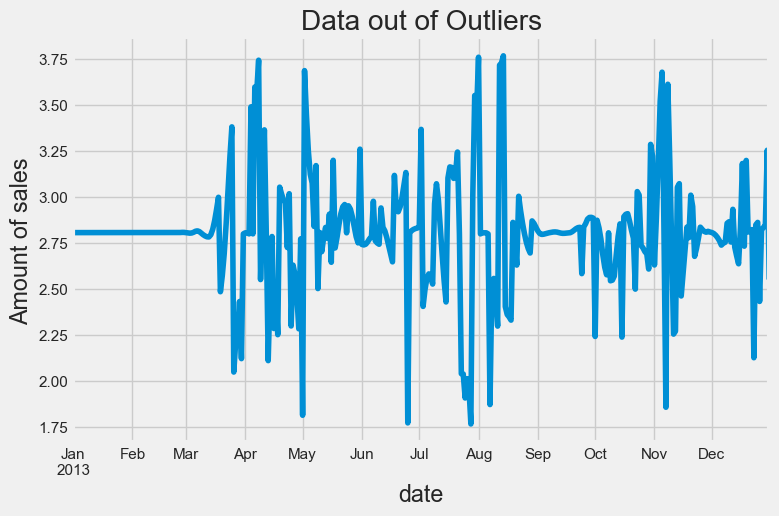

In [301]:
x.plot(title = "Data out of Outliers" , ylabel = "Amount of sales")
plt.show()

In [302]:
new_df.sales = x
new_df.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,2.805619,0.0
2013-01-02,0,SEAFOOD,2.805619,0.0
2013-01-03,0,SEAFOOD,2.805619,0.0
2013-01-04,0,SEAFOOD,2.805619,0.0
2013-01-05,0,SEAFOOD,2.805619,0.0


# Data Splitting

In [397]:
# Fit and evaluate the AR model
# Split the data into train and test sets

train_size = int(new_df.shape[0]*0.8)

train = new_df[:train_size]

test = new_df[train_size:]

In [398]:
train = train.reset_index()
test = test.reset_index()

In [399]:
X_train = train.drop("sales" , axis = 1)
X_test = test.drop("sales" , axis = 1)

Y_train = train.sales
Y_test = test.sales

# feature scaling and encoding

Feature scaling and encoding are two processes of transforming the data to make it more suitable for analysis, modeling, or visualization. Feature scaling and encoding can involve various methods, such as:

<b>Feature scaling:</b> changing the range or distribution of the data values, such as by standardization, normalization, or min-max scaling. Feature scaling can help to improve the performance or convergence of some models or algorithms that are sensitive to the scale of the data, such as distance-based or gradient-based methods.

<b>Feature encoding:</b> changing the type or format of the data values, such as by one-hot encoding, label encoding, or ordinal encoding. Feature encoding can help to convert categorical or ordinal data into numerical data that can be used by some models or algorithms that require numerical input, such as regression or classification methods

In [342]:
train.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [400]:
# Separate target and features
y = new_df["sales"]
X = new_df.drop("sales", axis=1)

In [401]:
# One-hot encode categorical column
from sklearn.preprocessing import OneHotEncoder
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# Import datetime module
import datetime

# Cast the date column to a string type
#X_train["date"] = X_train["date"].astype(str)
#X_test["date"] = X_test["date"].astype(str)

# Convert date column to ordinal values
#X_train["date"] = X_train["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").toordinal())
#X_test["date"] = X_test["date"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").toordinal())

# Create an encoder and a scaler object
encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()

# Scale the numerical columns as before
scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train[["date", "store_nbr", "onpromotion"]])
#X_test_scaled = scaler.transform(X_test[["date", "store_nbr", "onpromotion"]])

# Fit the encoder and scaler on the train data
encoder.fit(X_train[["family"]])
scaler.fit(X_train[["store_nbr", "onpromotion"]])

# Transform the train and test data using the fitted encoder and scaler
X_train_ohe = encoder.transform(X_train[["family"]])
X_test_ohe = encoder.transform(X_test[["family"]])
X_train_scaled = scaler.transform(X_train[["store_nbr", "onpromotion"]])
X_test_scaled = scaler.transform(X_test[["store_nbr", "onpromotion"]])

# Concatenate the encoded and scaled features
X_train_final = np.concatenate([X_train_ohe, X_train_scaled], axis=1)
X_test_final = np.concatenate([X_test_ohe, X_test_scaled], axis=1)                     

In [402]:
# Convert the encoded and scaled features to dataframes
X_train_final = pd.DataFrame(X_train_final, columns=["family_A", "family_B", "store_nbr", "onpromotion"])
X_test_final = pd.DataFrame(X_test_final, columns=["family_A", "family_B", "store_nbr", "onpromotion"])

In [403]:
X_train_final["date"] = train.date
X_test_final["date"] = test.date

In [380]:
X_test_final["date"] = test.reset_index().date

In [404]:
X_test_final.head()

,family_A,family_B,store_nbr,onpromotion,date
0,0.0,1.0,-0.256307,0.0,2013-10-20
1,0.0,1.0,-0.256307,0.0,2013-10-21
2,0.0,1.0,-0.256307,0.0,2013-10-22
3,0.0,1.0,-0.256307,0.0,2013-10-23
4,0.0,1.0,-0.256307,0.0,2013-10-24


In [405]:
d = X_train_final
d.head()

,family_A,family_B,store_nbr,onpromotion,date
0,1.0,0.0,3.901567,0.0,2013-01-01
1,0.0,1.0,-0.256307,0.0,2013-01-02
2,0.0,1.0,-0.256307,0.0,2013-01-03
3,0.0,1.0,-0.256307,0.0,2013-01-04
4,0.0,1.0,-0.256307,0.0,2013-01-05


In [406]:
d["sales"] = Y_train
d = d.set_index("date")
d.head()

,family_A,family_B,store_nbr,onpromotion,sales
date,,,,,
2013-01-01,1.0,0.0,3.901567,0.0,2.805619
2013-01-02,0.0,1.0,-0.256307,0.0,2.805619
2013-01-03,0.0,1.0,-0.256307,0.0,2.805619
2013-01-04,0.0,1.0,-0.256307,0.0,2.805619
2013-01-05,0.0,1.0,-0.256307,0.0,2.805619


# Modeling

Modeling in time series data is a process of building a mathematical or statistical representation of the data that can capture the patterns, trends, cycles, or relationships in the data. Modeling in time series data can be used to describe, explain, or predict the behavior of the data over time. 

In [386]:
model_trained = pd.DataFrame(columns = ["Model" , "MSE" , "MSLE" , "RMSE", "RMSLE"])

In [387]:
from sklearn.metrics import mean_squared_error , mean_squared_log_error

In [388]:
def calculator(model , y_test , pred):
    mse = mean_squared_error(y_test , pred)
    msle = mean_squared_log_error(y_test , pred)
    
    rmse = round( np.sqrt(mse) , 3)
    rmsle = round( np.sqrt(msle) , 3)
    
    new_row = {"Model": model,
               "MSE": mse,
               "MSLE": msle,
               "RMSE": rmse,
               "RMSLE": rmsle
          }
    
    return new_row

def test_calculator(y_test , pred):
    
    mse = mean_squared_error(y_test , pred)
    msle = mean_squared_log_error(y_test , pred)
    
    rmse = round( np.sqrt(mse) , 3)
    rmsle = round( np.sqrt(msle) , 3)
    
    dic = { "MSE" : mse , "MSLE" : msle , "RMSE" : rmse , "RMSLE" : rmsle}
    
    return dic

# 1. Autoregressive (AR) model

Autoregressive (AR) model is a type of time series model that assumes that the current value of the data depends linearly on its previous values, plus a random error term. Autoregressive model can be written as:

## Create the model

In [407]:
#import the library
import statsmodels.api as sm

#load a sample dataset
data = sm.datasets.sunspots.load_pandas().data['SUNACTIVITY']

#define the lag order
lags = 10

#fit the AR model
#model = sm.tsa.AutoReg(x_train lags , trend = "c" )

autoreg_model = sm.tsa.AutoReg(d.sales , lags ,  trend = "c" )

## Train the Model

In [408]:
autoreg_results = autoreg_model.fit()

#display the model summary
autoreg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                  292
Model:                    AutoReg(10)   Log Likelihood                 -24.223
Method:               Conditional MLE   S.D. of innovations              0.264
Date:                Thu, 20 Jul 2023   AIC                             72.446
Time:                        05:56:16   BIC                            116.149
Sample:                    01-11-2013   HQIC                            89.972
                         - 10-19-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3889      0.458      7.406      0.000       2.492       4.286
sales.L1       0.3160      0.060      5.307      0.000       0.199       0.433
sales.L2       0.0465      0.062      0.748      0.455      -0.075       0.168
sales.L3      -0.1048      0.062     -1.692      0.091      -0.226       0.017
sales.L4      -0.0058      0.061     -0.095      0.924      -0.126       0.114
sales.L5      -0.1408      0.062     -2.283      0.022      -0.262      -0.020
sales.L6      -0.1126      0.062     -1.824      0.068      -0.234       0.008
sales.L7      -0.1817      0.062     -2.925      0.003      -0.303      -0.060
sales.L8       0.0971      0.063      1.548      0.122      -0.026       0.220
sales.L9      -0.1090      0.063     -1.733      0.083      -0.232       0.014
sales.L10     -0.0181      0.060     -0.300      0.764      -0.136       0.100
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1553           -0.0000j            1.1553           -0.5000
AR.2            -0.8699           -0.8921j            1.2461           -0.3730
AR.3            -0.8699           +0.8921j            1.2461            0.3730
AR.4             0.9904           -0.4918j            1.1058           -0.0734
AR.5             0.9904           +0.4918j            1.1058            0.0734
AR.6             0.0342           -1.2495j            1.2500           -0.2456
AR.7             0.0342           +1.2495j            1.2500            0.2456
AR.8             0.9025           -1.2225j            1.5196           -0.1488
AR.9             0.9025           +1.2225j            1.5196            0.1488
AR.10           -6.9793           -0.0000j            6.9793           -0.5000
------------------------------------------------------------------------------
"""

## Predict on a unknown dataset (Testset)

In [409]:
#predict using x_test
test_autoreg = autoreg_results.predict(start = X_test_final.date.min() , end = X_test_final.date.max())

# Forecast the test set
#forecast = autoreg_results.predict(start=test.index[0], end=test.index[-1])

#pred = results.predict(x_test)
test_autoreg.head()

2013-10-20    2.900840
2013-10-21    2.870966
2013-10-22    2.897154
2013-10-23    2.710902
2013-10-24    2.788586
Freq: D, dtype: float64

In [410]:
# Checking for negative values
(test_autoreg < 0).any()

False

In [411]:
# Append the new row to the dataframe
model_trained = model_trained.append(calculator("AutoReg" , Y_test , test_autoreg ), ignore_index=True)
model_trained

,Model,MSE,MSLE,RMSE,RMSLE
0,AutoReg,0.084669,0.005885,0.291,0.077


# 2. ARIMA Model

Autoregressive integrated moving average (ARIMA) model is a type of time series model that combines the features of autoregressive (AR) and moving average (MA) models, and also allows for differencing the data to make it stationary.

In [412]:
# Import statsmodels library
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with chosen parameters
arima_model = ARIMA(d.sales, order=(1, 1, 2))

## Train the Model

In [413]:
fitted = arima_model.fit()

# Print model summary
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -70.331
Date:                Thu, 20 Jul 2023   AIC                            148.662
Time:                        05:58:10   BIC                            163.355
Sample:                    01-01-2013   HQIC                           154.548
                         - 10-19-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9313      0.129     -7.234      0.000      -1.184      -0.679
ma.L1          0.4715      0.130      3.631      0.000       0.217       0.726
ma.L2         -0.3899      0.101     -3.845      0.0

## Predict on a unknown dataset (Testset)

In [414]:
# Predict the values of the test set
test_arima = fitted.predict(start = X_test_final.date.min() , end = X_test_final.date.max())

In [415]:
# Append the new row to the dataframe
model_trained = model_trained.append(calculator("ARIMA" , Y_test , test_arima ), ignore_index=True)
model_trained

,Model,MSE,MSLE,RMSE,RMSLE
0,AutoReg,0.084669,0.005885,0.291,0.077
1,ARIMA,0.086607,0.006140,0.294,0.078


# SARIMAX

Seasonal autoregressive integrated moving average with exogenous variables (SARIMAX) model is a type of time series model that extends the ARIMA model by adding a seasonal component and external or exogenous variables. S

In [416]:
# Import the library
import statsmodels.api as sm

# Define the endogenous and exogenous variables
#ExogenousFeature_train = data['temperature'] # The external variable

# Define the model parameters
order = (1, 0, 0) # The ARIMA order
seasonal_order = (2, 1, 0, 7) # The seasonal order

## Train the Model

In [417]:
# Create and fit the model
SARIMA_model = sm.tsa.SARIMAX(endog=d.sales.astype('float64'), 
                              exog = None,
                              #exog=ExogenousFeature_train.values.astype('float64'), 
                              order=order, 
                              seasonal_order=seasonal_order, 
                              simple_differencing=False)
model_results = SARIMA_model.fit()

## Predict on a unknown dataset (Testset)

In [418]:
# Make predictions
test_sarima_pred = model_results.predict(start=X_test_final.date.min(), # The first date of the test set
                             end=X_test_final.date.max(), # The last date of the test set
                             exog = None,
                             #exog=x_test.values.astype('float64'), # The exogenous variable for the test set
                             dynamic=False)

In [419]:
test_sarima_pred.head()

2013-10-20    2.776888
2013-10-21    2.737546
2013-10-22    2.531433
2013-10-23    2.709099
2013-10-24    2.694485
Freq: D, Name: predicted_mean, dtype: float64

In [420]:
# Append the new row to the dataframe
model_trained = model_trained.append(calculator("SARIMAX" , Y_test , test_sarima_pred ), ignore_index=True)
model_trained

,Model,MSE,MSLE,RMSE,RMSLE
0,AutoReg,0.084669,0.005885,0.291,0.077
1,ARIMA,0.086607,0.006140,0.294,0.078
2,SARIMAX,0.107038,0.007412,0.327,0.086


# Simple Exponential Smoothing model

Simple exponential smoothing (SES) model is a type of time series model that uses a weighted average of past values to forecast the future values, with more weight given to the recent values

## Train the model

In [421]:
# Import the library
import statsmodels.api as sm

# Create and fit the model
SES_model = sm.tsa.SimpleExpSmoothing(d.sales.astype('float64')).fit()

# Print the model summary
print(SES_model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  sales   No. Observations:                  292
Model:             SimpleExpSmoothing   SSE                             26.832
Optimized:                       True   AIC                           -693.046
Trend:                           None   BIC                           -685.693
Seasonal:                        None   AICC                          -692.907
Seasonal Periods:                None   Date:                 Thu, 20 Jul 2023
Box-Cox:                        False   Time:                         06:00:37
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level           1.4901e-08                alpha                 True
initial_level              2.8056189                

## Predict on a unknown dataset (Testset)

In [422]:
# Make predictions
test_ses_pred = SES_model.predict(start = X_test_final.date.min(), end = X_test_final.date.max())

In [423]:
# Append the new row to the dataframe
model_trained = model_trained.append(calculator("SES" , Y_test , test_ses_pred ), ignore_index=True)
model_trained

,Model,MSE,MSLE,RMSE,RMSLE
0,AutoReg,0.084669,0.005885,0.291,0.077
1,ARIMA,0.086607,0.006140,0.294,0.078
2,SARIMAX,0.107038,0.007412,0.327,0.086
3,SES,0.083319,0.005810,0.289,0.076


# Hyper parameter tuning

Hyperparameter tuning in time series is a process of finding the optimal values of the parameters that control the behavior or performance of a time series model or method. Hyperparameters are the parameters that are not learned from the data, but are set by the user or the analyst, such as the order of an ARIMA model, the smoothing factor of an exponential smoothing model, or the number of clusters in a clustering method.

In [424]:
p_values = range(0,5)
d__values = range(0,5)
q_values = range(0,5)

In [425]:
 model = ARIMA( d.sales , order = (0 , 0, 0))

In [427]:
max_order = 1
for p in p_values:
   for m in d__values:
    for q in q_values:
        order = ( p , m , q)
        predictions = list()
        dic = {}
        model = ARIMA( d.sales , order = order)
        #arima_model = ARIMA(d.sales, order=(1, 1, 2))
        model_fit = model.fit()
        pred = model_fit.predict(start = X_test_final.date.min() , end = X_test_final.date.max())
        if (( pred < 0).any() ):
            continue
        predictions.append(pred)
        msle = mean_squared_log_error(Y_test , pred)
        rmsle = np.sqrt(msle)
        
        # add value to dictionary
                
        if (float( rmsle) == float(0)):
            continue
        
        # selecting the best score
        if (rmsle < max_order):
            max_order = rmsle
            best_order = order
        
        dic[(p,m,q)] = {'rmsle': rmsle}
        
        print("ARIMA%s , RMSLE =  %.2f"% (order, rmsle) )

max_order

       # test_autoreg = autoreg_results.predict(start = X_test_final.date.min() , end = X_test_final.date.max())


ARIMA(0, 0, 0) , RMSLE =  0.08
ARIMA(0, 0, 1) , RMSLE =  0.08
ARIMA(0, 0, 2) , RMSLE =  0.08
ARIMA(0, 0, 3) , RMSLE =  0.08
ARIMA(0, 0, 4) , RMSLE =  0.08
ARIMA(0, 1, 0) , RMSLE =  0.08
ARIMA(0, 1, 1) , RMSLE =  0.08
ARIMA(0, 1, 2) , RMSLE =  0.08
ARIMA(0, 1, 3) , RMSLE =  0.08
ARIMA(0, 1, 4) , RMSLE =  0.08
ARIMA(0, 2, 1) , RMSLE =  0.08
ARIMA(0, 2, 2) , RMSLE =  0.08
ARIMA(0, 2, 3) , RMSLE =  0.08
ARIMA(0, 2, 4) , RMSLE =  0.08
ARIMA(0, 3, 2) , RMSLE =  0.09
ARIMA(0, 3, 3) , RMSLE =  0.08
ARIMA(0, 3, 4) , RMSLE =  0.08
ARIMA(0, 4, 3) , RMSLE =  0.27
ARIMA(0, 4, 4) , RMSLE =  0.11
ARIMA(1, 0, 0) , RMSLE =  0.08
ARIMA(1, 0, 1) , RMSLE =  0.08
ARIMA(1, 0, 2) , RMSLE =  0.08
ARIMA(1, 0, 3) , RMSLE =  0.08
ARIMA(1, 0, 4) , RMSLE =  0.08
ARIMA(1, 1, 0) , RMSLE =  0.08
ARIMA(1, 1, 1) , RMSLE =  0.08
ARIMA(1, 1, 2) , RMSLE =  0.08
ARIMA(1, 1, 3) , RMSLE =  0.08
ARIMA(1, 1, 4) , RMSLE =  0.08
ARIMA(1, 2, 0) , RMSLE =  0.32
ARIMA(1, 2, 1) , RMSLE =  0.08
ARIMA(1, 2, 2) , RMSLE =  0.08
ARIMA(1,

0.07610375722944594

In [428]:
best_order

(4, 0, 3)

In [429]:
 model = ARIMA( d.sales , order = best_order)

In [430]:
model_fit = model.fit()

In [431]:
pred = model_fit.predict(start = X_test_final.date.min() , end = X_test_final.date.max())

# check if the model is overfitting or not using test and eval data set

In [432]:
nw  = new_df.reset_index()

# Split the data into train and test sets

train_size = int(nw.shape[0]*0.6)

train = nw[:train_size]

both = nw[train_size:]

In [433]:
both_size = int(both.shape[0]*0.5)

test = both[:both_size]

eval = both[both_size:]

In [434]:
model = ARIMA( train.sales , order = best_order)
pred = model_fit.predict(start = test.date.min() , end = test.date.max())
rmsle = mean_squared_log_error(test.sales, pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


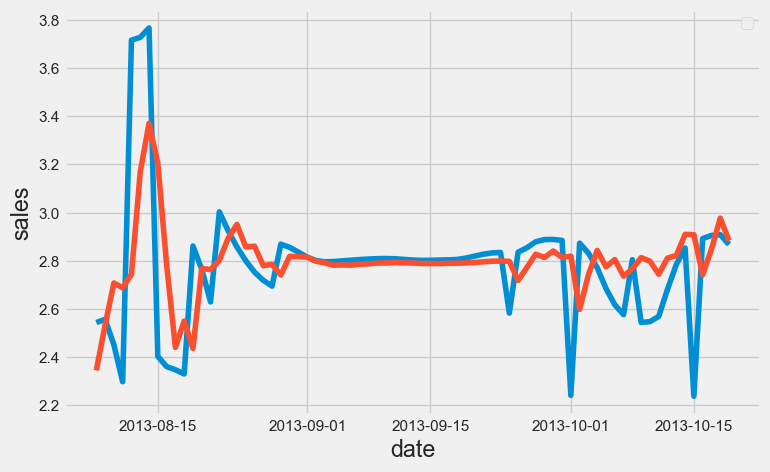

In [435]:
plt.style.use("fivethirtyeight")
sns.lineplot(x = test.date , y = test.sales , legend="full")
sns.lineplot(x = test.date , y = pred.values)
plt.legend()
plt.show()
